## Projet 7 : Mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé.

### Partie-3 : Modélisation

  - [Chargement des données](#Chargement-des-données)
  - [Variable cible : TARGET](#Variable-cible-:-TARGET)
  - [Diviser les données en ensembles d'entraînement et de test](#Diviser-les-données-en-ensembles-d'entraînement-et-de-test)
  - [Standardisation des données](#Standardisation-des-données)
  - [Èlaboration des modèles](#Èlaboration-des-modèles)
       * [1 - Re-équilibrage des données](#1---Re-équilibrage-des-données)
       * [2 - Mesures de pérformances](#2---Mesures-de-pérformances)
       * [3 - Entrainement et évaluation des modéles](#3---Entrainement-et-évaluation-des-modéles)
           * [DummyClassifier](#DummyClassifier)
           * [RandomForestClassifier](#RandomForestClassifier)
           * [LGBMClassifier](#LGBMClassifier)
       * [4 - Visualisation, évaluation et intérprétation des résultats](#4---Visualisation,-évaluation-et-intérprétation-des-résultats)
       * [5 - Matrice de confusion et la courbe ROC/AUC](#5---Matrice-de-confusion-et-la-courbe-ROC/AUC)
       * [6 - Optimisation métrique métier](#6---Optimisation-métrique-métier)
       * [7 - Optimisation métrique technique : f1_score](#7---Optimisation-métrique-technique-:-f1_score)
       * [8 - Interprétabilité](#8---Interprétabilité)

  - [Enregistrement du modèle](#Enregistrement-du-modèle)
  - [Conclusion](#Conclusion) 


### Importer les modules nécéssaires 

In [1]:
import numpy as np
import pandas as pd

In [2]:
from collections import Counter
import gc
import time
import re
from contextlib import contextmanager

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.impute import SimpleImputer

In [5]:
from sklearn.metrics import   make_scorer ,roc_curve,  classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score,f1_score, precision_score, recall_score ,average_precision_score


In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as imbPipeline


from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier


In [7]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

import shap

In [8]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict

In [9]:
import pickle
import joblib

In [10]:
import fonctionsUtiles as fctUtiles

###### Chargement des données

In [11]:
df_final = pd.read_csv('./data/preprocessed_data/df_final.csv')

In [12]:
fctUtiles.formats(df_final,'Jeu de données')

,Nbre de lignes,Nbre de variables
Jeu de données,307507,291


- Pour des raisons matériels, nous travaillerons sur un échantillon de 100000 obsérvations

In [13]:
df_final = df_final.sample(100000)

###### Variable cible : TARGET

In [14]:
df_final.TARGET.value_counts()

0.0    91927
1.0     8073
Name: TARGET, dtype: int64

<Axes: title={'center': 'Proportion de la valeur cible'}, ylabel='TARGET'>

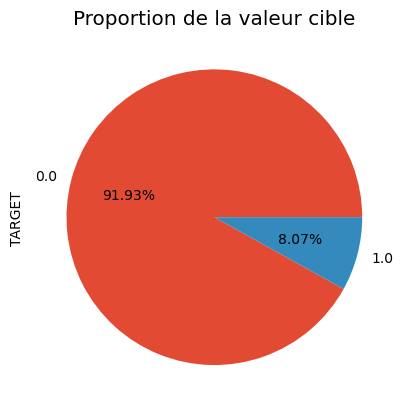

In [15]:
df_final.TARGET.value_counts().plot.pie(autopct='%1.2f%%', title='Proportion de la valeur cible')
#fig.subplots_adjust(wspace=0.5)

- Nous constations que notre jeu de données est trés déséquilibré, la modalité 0 est trés largement majoritaire.
- Les modéles sont sensibles aux données déséquilibrées. Nous procéderons à un ré-equilibrage avant l'entrainement des modèles 

###### Diviser les données en ensembles d'entraînement et de test

In [16]:
target = df_final.TARGET
inputs = df_final.drop(columns=['TARGET','SK_ID_CURR'])
inputs_with_ids = df_final.drop(columns=['TARGET'])

In [17]:
# Split des données
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2, random_state=42)

In [18]:
X_train.shape, X_test.shape

((80000, 289), (20000, 289))

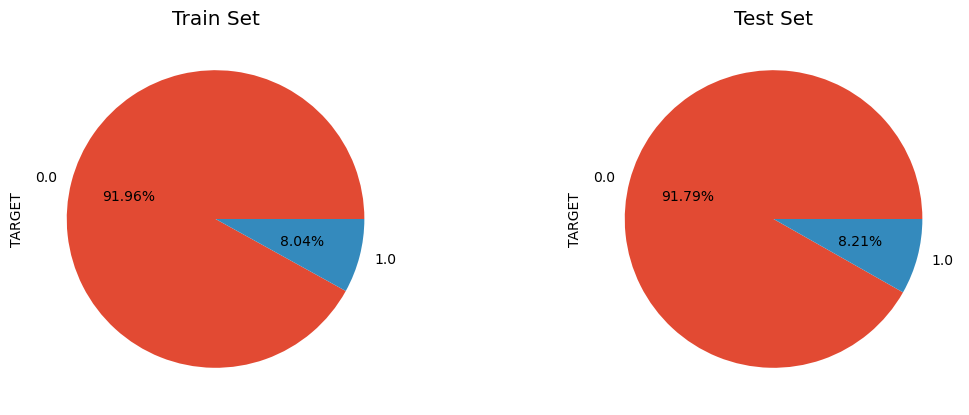

In [19]:
# Afficher la proportion de la valeur cible dans l'ensemble d'entraînement et d'évaluation
fig, ax = plt.subplots(1,2, figsize=(12,6))
y_train.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[0], title='Train Set')
y_test.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[1], title='Test Set')
fig.subplots_adjust(wspace=0.5)

- Nous constatons que les proportions de la valeur cible est quasi identique dans les 2 ensembles

In [20]:
# On sauvegarde en csv les données test qui seront nos clients d'exemples pour l'api flask et le dashboard
index_test = X_test.index.tolist()
X_test_with_id = inputs_with_ids.loc[index_test]
X_test_with_id.to_csv('data_test.csv',index=False)

###### Standardisation des données

In [21]:
X_train_preprocess = X_train.copy()
X_test_preprocess = X_test.copy()

In [22]:
# Scale each feature to 0-1
scaler = StandardScaler()
# fit with the scaler
scaler.fit(X_train_preprocess)

X_train_preprocess = scaler.transform(X_train_preprocess)
X_test_preprocess = scaler.transform(X_test_preprocess)

xtrain = pd.DataFrame(X_train_preprocess, index=X_train.index, columns=X_train.columns)

xtest = pd.DataFrame(X_test_preprocess, index=X_test.index, columns=X_test.columns)

In [24]:
xtrain.shape

(80000, 289)

In [23]:
del df_final, target, inputs, inputs_with_ids
del index_test, X_test_with_id, X_train, X_test
del X_train_preprocess, X_test_preprocess

In [41]:
gc.collect()

5018

In [34]:
    pred_proba = {
        'prediction': [2],
        'proba': [3.1]
    }

In [35]:
pred_proba

{'prediction': [2], 'proba': [3.1]}

###### Èlaboration des modèles

###### 1 - Re-équilibrage des données

In [24]:
def underOverSampling(Xtrain, ytrain, over, under):
    #Définition du pipeline
    over = SMOTE(sampling_strategy=over, random_state = 42)
    under = RandomUnderSampler(sampling_strategy=under, random_state = 42)
    steps = [('o',over),('u',under)]
    pipeline = imbPipeline(steps=steps)

    return pipeline.fit_resample(xtrain , ytrain)

In [25]:
X, y = underOverSampling(xtrain , y_train, 0.1, 0.9)
counter = Counter(y)
print(counter)

Counter({0.0: 8161, 1.0: 7345})


###### 2 - Mesures de pérformances

- Nous utiliserons les mesures de pérformances suivantes pour le choix de notre meilleur modèle :
    * La courbe ROC et AUC
    * Précision, rappel et le F1-score

In [26]:
results = pd.DataFrame(columns=["Algorithme", "Balancing_method",
                                "AUC_train", "AUC_test","Time"])

###### 3 - Entrainement et évaluation des modéles

In [27]:
def evaluate_model(gs, x, y, x_test, y_test, model_name, balancing_method):
    
    #Entrainement
    start = time.time()
    model = gs.fit(x,y)
    end = time.time()-start

    if (model_name != 'Baseline'):
        df_results = pd.DataFrame.from_dict(model.cv_results_)

    #Training Performance
    if (model_name == 'Baseline'):
        
        y_proba = model.predict_proba(x)

        auc_train = round(roc_auc_score(y, y_proba[:,1]),3) 
        
    else:
        auc_train = round(model.best_score_,3) 
        

    #Testing Performance
    y_pred = model.predict(x_test)
    y_proba = model.predict_proba(x_test)
    auc_test = round(roc_auc_score(y_test, y_proba[:,1]),3) 
   
    

    row = [model_name, 
            balancing_method,
            auc_train, 
            auc_test,
            end]

    return row 


###### DummyClassifier

In [44]:
dc = DummyClassifier(strategy="stratified")

In [45]:
row = evaluate_model(dc, X, y, xtest, y_test, \
                        "Baseline", "UnderOverSampling")
results.loc[len(results)] = row

,Algorithme,Balancing_method,AUC_train,AUC_test,Time
0,Baseline,UnderOverSampling,0.497,0.499,0.001202


In [46]:
row = evaluate_model(dc ,xtrain, y_train, xtest, y_test, \
                        "Baseline", "Balanced")

results.loc[len(results)] = row

,Algorithme,Balancing_method,AUC_train,AUC_test,Time
0,Baseline,UnderOverSampling,0.497,0.499,0.001202
1,Baseline,Balanced,0.498,0.501,0.002742


###### RandomForestClassifier

In [47]:
rf = RandomForestClassifier(random_state = 42)

rf_balanced = RandomForestClassifier(random_state = 42, class_weight="balanced")

In [48]:
# Recherche des hypérparamétres 
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10]
}

gs_rf = GridSearchCV(
    rf,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

gs_rf_balanced = GridSearchCV(
    rf_balanced,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

In [49]:
row = evaluate_model(gs_rf, X, y, xtest, y_test, "RandomForest", "UnderOverSampling")

results.loc[len(results)] = row

In [50]:
row = evaluate_model(gs_rf_balanced ,xtrain, y_train, xtest, y_test, "RandomForest", "Balanced")
results.loc[len(results)] = row

,Algorithme,Balancing_method,AUC_train,AUC_test,Time
0,Baseline,UnderOverSampling,0.497,0.499,0.001202
1,Baseline,Balanced,0.498,0.501,0.002742
2,RandomForest,UnderOverSampling,0.751,0.736,18.757621
3,RandomForest,Balanced,0.735,0.728,92.943099


###### LGBMClassifier

In [28]:
lgbm = LGBMClassifier(random_state = 42, objective = 'binary')

lgbm_balanced = LGBMClassifier(random_state = 42,
                                   objective = 'binary',
                                   class_weight = 'balanced')

In [29]:
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05]
}

gs_lgbm = GridSearchCV(
    lgbm,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

gs_lgbm_balanced = GridSearchCV(
    lgbm_balanced,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

In [53]:
row = evaluate_model(gs_lgbm, X, y, xtest, y_test, "LGBM", "UnderOverSampling")
results.loc[len(results)] = row

In [30]:
row = evaluate_model(gs_lgbm_balanced, xtrain, y_train, xtest, y_test, "LGBM", "Balanced")
results.loc[len(results)] = row

In [31]:
results.sort_values('AUC_train', ascending=False)

,Algorithme,Balancing_method,AUC_train,AUC_test,Time
0,LGBM,Balanced,0.765,0.769,42.926947


###### 4 - Visualisation, évaluation et intérprétation des résultats

- Visualisation

In [47]:
def plotComparaisonResults(metrics_compare, metric):
    
    fig, ax = plt.subplots()
    
    # create data
    x = np.arange(3)
    y1 = metrics_compare [metrics_compare['Balancing_method'] == "UnderOverSampling"][metric]
    y2 = metrics_compare [metrics_compare['Balancing_method'] == "Balanced"][metric]
    width = 0.2

    # plot data in grouped manner of bar type
    b1 = plt.bar(x-0.2, y1, width)
    b2 = plt.bar(x, y2, width)
    plt.xticks(x, ['Baseline', 'RandomForest', 'LGBM'])

    if (metric =="AUC_train"):
        plt.title('AUC des modèles (train)')
    
    if(metric =="AUC_test"):
        plt.title('AUC des modèles (test)')

    if (metric =="Time"):
        plt.ylabel("Time (sec)")
        plt.title("Temps d'exécution du fit")    
    else:
        plt.ylabel("AUC score")
    plt.legend(["UnderOverSampling", "Balanced"], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

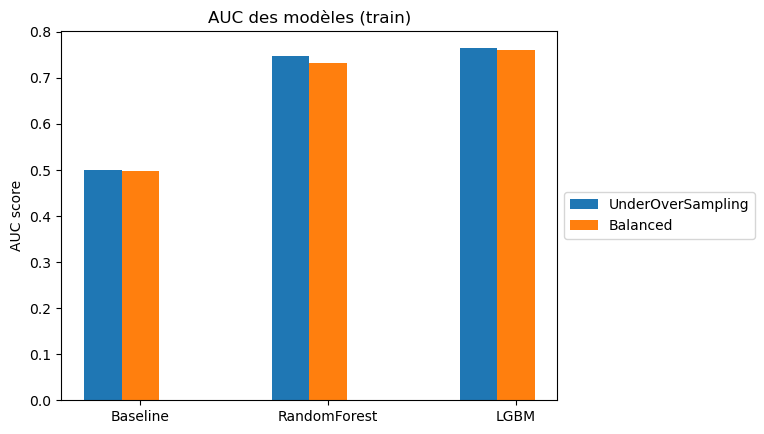

In [48]:
plotComparaisonResults(results, 'AUC_train')

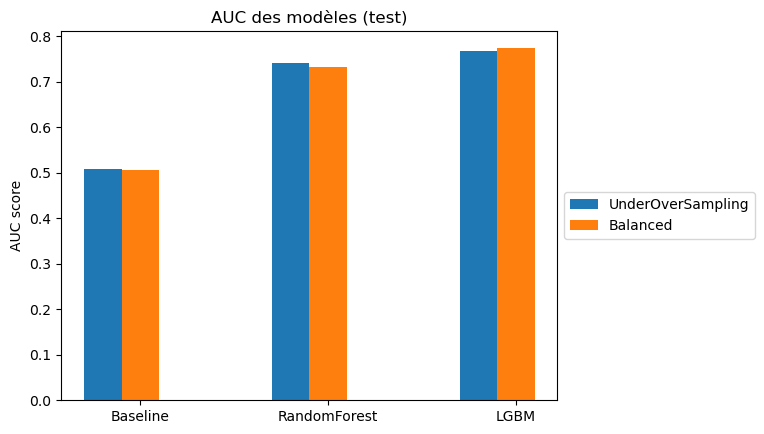

In [49]:
plotComparaisonResults(results, 'AUC_test')

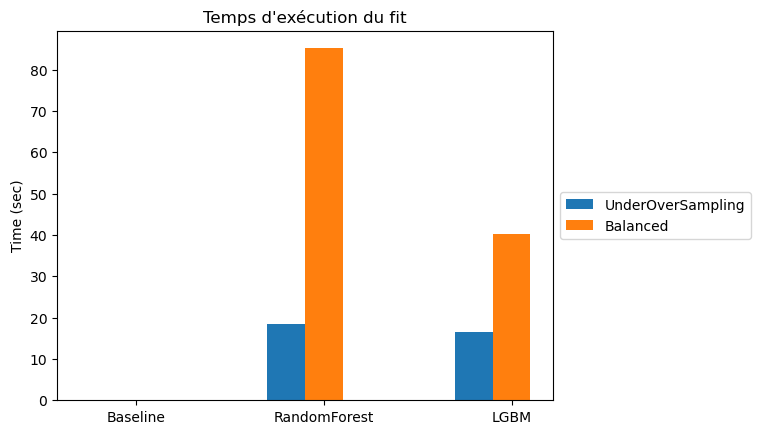

In [50]:
plotComparaisonResults(results, 'Time')

- Èvaluation des modèles : précision, rappel et F1-score

In [58]:
# Èvaluation des modèles
def classif_report(gs, x, y, x_test, y_test):
    
    #Entrainement
    start = time.time()
    model = gs.fit(x,y)
    end = time.time()-start
    y_pred = model.predict(x_test)
 

    return print (classification_report(y_test, y_pred))

- Modèles RandomForest

In [59]:
classif_report(gs_rf, X, y, xtest, y_test)

              precision    recall  f1-score   support

         0.0       0.96      0.75      0.84     18446
         1.0       0.17      0.59      0.26      1554

    accuracy                           0.74     20000
   macro avg       0.56      0.67      0.55     20000
weighted avg       0.89      0.74      0.80     20000



In [60]:
classif_report(gs_rf_balanced, xtrain, y_train, xtest, y_test)

              precision    recall  f1-score   support

         0.0       0.95      0.83      0.89     18446
         1.0       0.19      0.47      0.27      1554

    accuracy                           0.81     20000
   macro avg       0.57      0.65      0.58     20000
weighted avg       0.89      0.81      0.84     20000



- Modèles LGBMClassifier

In [61]:
classif_report(gs_lgbm, X, y, xtest, y_test)

              precision    recall  f1-score   support

         0.0       0.96      0.76      0.85     18446
         1.0       0.18      0.61      0.27      1554

    accuracy                           0.75     20000
   macro avg       0.57      0.69      0.56     20000
weighted avg       0.90      0.75      0.80     20000



In [62]:
classif_report(gs_lgbm_balanced, X, y, xtest, y_test)

              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83     18446
         1.0       0.17      0.63      0.26      1554

    accuracy                           0.72     20000
   macro avg       0.56      0.68      0.55     20000
weighted avg       0.90      0.72      0.79     20000



- La mesure AUC nous suggére de retenir le modèle LGBMClassifier avec un équilibrage de données UnderOverSampling
- Les mesures précision, rappel et F1-score indiquent que le meilleur modèle est le RandomForestClassier avec un équilibrage intégré
- Vu notre problématique, qui est de pénaliser les faux négatifs, on a retenu le modèle qui obtient la meilleur résultat en terme de l'AUC, càd, le LGBMClassifier

###### 5 - Matrice de confusion et la courbe ROC/AUC

In [63]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, roc_auc, title):
    '''
    This function will make a pretty plot of 
       an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.
    '''
    fig = plt.figure(figsize=(18,12))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    fig.suptitle(title, fontsize="30", fontweight="bold")
    plt.show()

In [70]:
gs_lgbm.fit(X,y)
y_proba = gs_lgbm.predict_proba(xtest)
roc_auc = round(roc_auc_score(y_test, y_proba[:,1]),3)

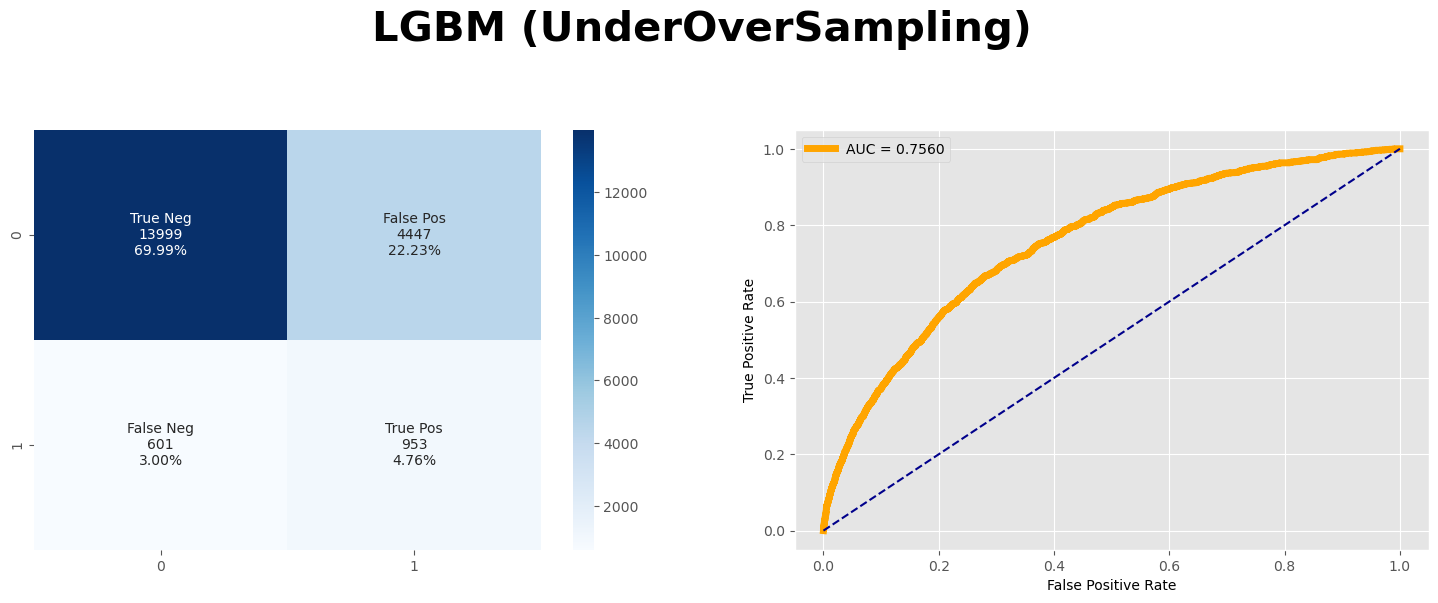

In [71]:
cf_matrix_roc_auc(gs_lgbm, y_test, gs_lgbm.predict(xtest),\
                  gs_lgbm.predict_proba(xtest)[:,1], roc_auc,"LGBM (UnderOverSampling) ")

- Le modèle classe incorrectement 3% de mauvais clients comme bons clients (faux négatifs)
- Et classe aussi incorrectement 22% de bons clients comme mauvais (faux positifs)

###### 6 - Optimisation métrique métier

La métrique banking, consiste à calculer le gain obtenu pour l'ensemble des individus du jeu de données.
Pour cela nous avons fixé un poids arbitraire pour chacune des prédictions relatif à leurs valeurs réelles.
Les valeurs des poids sont les suivantes :
- fn_value = -10
- tp_value = 0
- tn_value = 1
- fp_value = 0

De ce fait, les prêts accordés aux individus qui ne sont finalement pas solvables sont dotés d'une pénalisation négative de -10, alors que les prêts accordés aux individus finalement solvables rapportent 1. Ce rapport 10 est totalement arbitraire et il est tout à fait possible de changer ces valeurs à la convenance de l'optique métier. Il faudra cependant relancer l'optimisation des hyper-paramètres du modèle.

In [89]:
def bank_score(y_true, y_pred, fn_value=-10, fp_value=0, tp_value=0, tn_value=1):

    # Matrice de Confusion
    mat_conf = confusion_matrix(y_true, y_pred)
    
    # Nombre de True Negatifs
    tn = mat_conf[0, 0]
    # Nombre de Faux Négatifs
    fn = mat_conf[1, 0]
    # Nombre de Faux Positifs
    fp = mat_conf[0, 1]
    # Nombre de True Positifs
    tp = mat_conf[1, 1]
    
    # Gain total
    gain  = tp*tp_value + tn*tn_value + fp*fp_value + fn*fn_value
    
    # Gain maximum 
    max_gain  = (fp + tn)*tn_value + (fn + tp)*tp_value
    
    # Gain minimum 
    min_gain  = (fp + tn)*fp_value + (fn + tp)*fn_value
    
    # Gain normalisé entre 0 et 1
    gain_normalized = ( gain  - min_gain )/(max_gain - min_gain )
    
    return gain_normalized   # Retourne la fonction d'évaluation

- https://learn.microsoft.com/fr-fr/azure/databricks/machine-learning/automl-hyperparam-tuning/

- Nous allons à nouveau effectuer une nouvelle recherche des hyper-paramètres via HyperOpt se basant sur la fonction métier proposée, de cette façon, ils seront choisis de sorte à minimiser la perte pour l'entreprise.

In [90]:
# Espace des paramètres
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 800, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 10),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20),
    'solvability_threshold': hp.quniform('solvability_threshold', 0.0, 1.0, 0.025)
}

def objective(params, eval_metric='bank_score'):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda']
        }
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model,  X, y, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'bank_score': 
        y_pred = cross_val_predict(model,  X, y, method='predict', cv=cv)
        score = bank_score( y, y_pred)
    elif eval_metric == 'F1':
        model.fit( X, y)
        y_pred = model.predict(xtest)
        score = fbeta_score(y_test, y_pred, beta=1)

  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}


In [93]:
best_params = fmin(fn=objective, space=space, max_evals=10, algo=tpe.suggest)

100%|█| 10/10 [02:32<00:00, 15.28s/trial, best los


In [96]:
# Affichage des meilleurs hyper-paramètres
best_params

{'colsample_bytree': 0.759979968087239,
 'learning_rate': 0.018823666754370083,
 'max_depth': 10.0,
 'n_estimators': 600.0,
 'reg_lambda': 3.805891444447603,
 'solvability_threshold': 0.775,
 'subsample': 0.9257297863473852}

Le meilleur seuil de solvabilité est de 0.775, i.e tous les individus dont les valeurs de prédictions sont inférieurs à 0.775 ne sont pas solvables.

In [105]:
%%time
    
lgbm_nv = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best_params['n_estimators']), 
    colsample_bytree= best_params['colsample_bytree'],
    learning_rate= best_params['learning_rate'],
    max_depth= int(best_params['max_depth']),
    subsample= best_params['subsample'],
    reg_lambda= best_params['reg_lambda'],
    )

lgbm_nv.fit(X, y)

CPU times: user 32.5 s, sys: 477 ms, total: 33 s
Wall time: 5.83 s


LGBMClassifier(colsample_bytree=0.759979968087239,
               learning_rate=0.018823666754370083, max_depth=10,
               n_estimators=600, reg_lambda=3.805891444447603,
               subsample=0.9257297863473852)

In [106]:
roc_auc = roc_auc_score(y_test, lgbm_nv.predict_proba(xtest)[:,1])
print('AUC : %0.4f' %roc_auc)

AUC : 0.7598


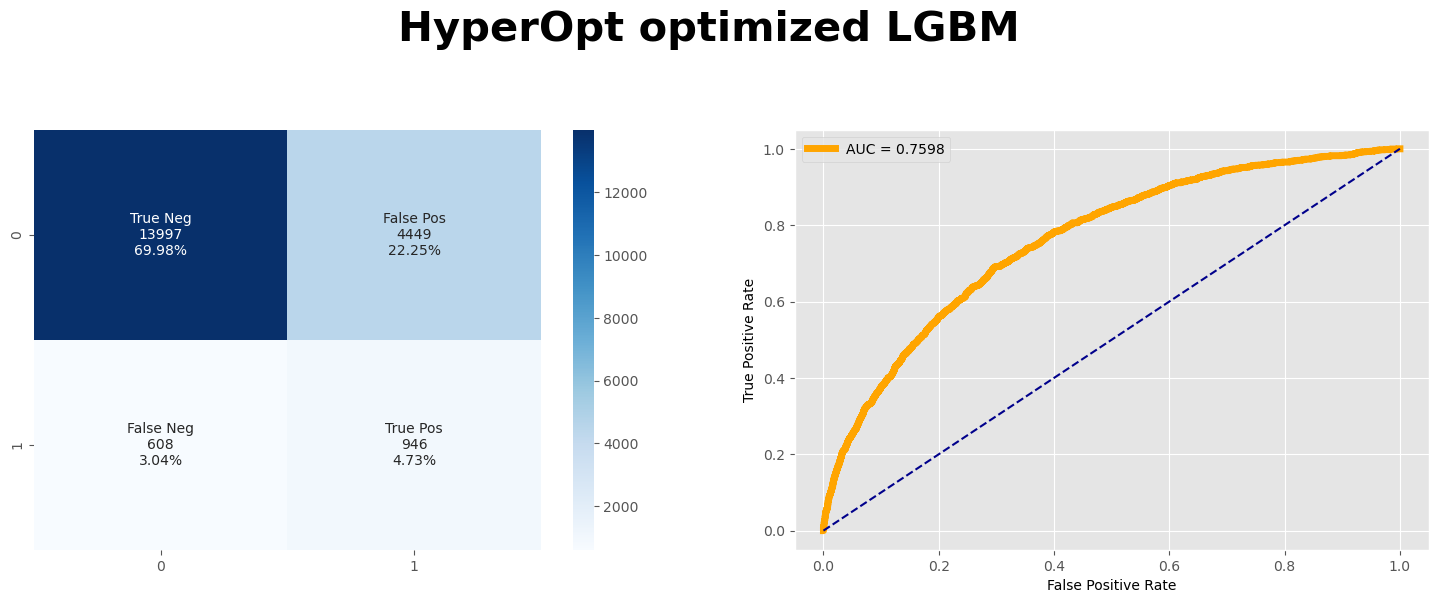

In [107]:
cf_matrix_roc_auc(lgbm_nv, y_test, lgbm_nv.predict(xtest), lgbm_nv.predict_proba(xtest)[:,1],roc_auc, "HyperOpt optimized LGBM")

- Èvolution du gain en fonction du seuil de solvabilité

In [109]:
def gain_seuil(clf, y_set, x_set):
    
    """
    Evolution du gain en fonction du seuil de solvabilité fixé
    Si score < seuil : client solvable
    Sinon : client non solvable
    
    """
    cost_function = []
    threshold_x = np.linspace(0.0, 1, 20)
    
    for threshold in threshold_x:
        
        # Score du modèle : 0 à 1
        y_scores = clf.predict_proba(x_set)[:, 1]
        
        # Score > seuil de solvabilité : retourne 1 sinon 0
        y_pred = (y_scores > threshold)
        
        y_pred = np.array(y_pred > 0) * 1
        # Calcul de l'indice bancaire
        cost_function.append(bank_score(y_set, y_pred))
        
    # Affichage du gain en fonction du seuil de solvabilité    
    plt.plot(threshold_x, cost_function)
    plt.xlabel("Seuil de probabilité")
    plt.ylabel("Indice banquaire")
    plt.xticks(np.linspace(0.1, 1, 10))

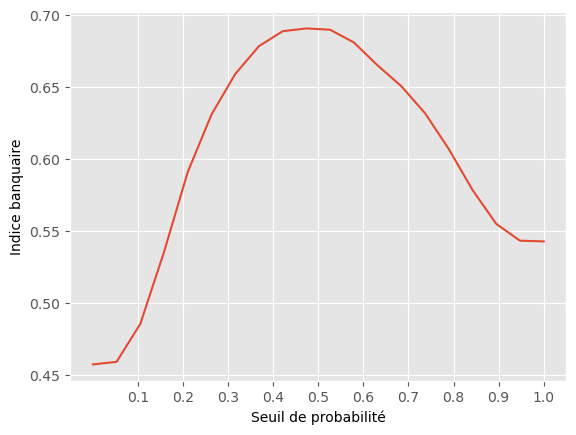

In [110]:
# Affiche le meilleur seuil de probabilité
gain_seuil(lgbm_nv, y_test, xtest)

- On retrouve le fait que le meilleur seuil de solvabilité est proche de 0.35 comme celui trouvé par l'optimisation via hyperopt.

- Le gain obtenu avec un seuil de 0.35 est plus conséquent que pour un seuil par défaut de 0.5 fixé par LGBM

###### 7 - Optimisation métrique technique : f1_score

In [119]:
best2 = fmin(fn=objective, space=space, max_evals=10, algo=tpe.suggest)

100%|█| 10/10 [03:28<00:00, 20.83s/trial, best los


In [120]:
# Affichage des meilleurs hyper-paramètres
best2

{'colsample_bytree': 0.8404295725094022,
 'learning_rate': 0.025312170854233807,
 'max_depth': 0.0,
 'n_estimators': 700.0,
 'reg_lambda': 14.842015573857557,
 'solvability_threshold': 0.75,
 'subsample': 0.9099173691631718}

In [121]:
%%time

    
lgbm_2 = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best2['n_estimators']), 
    colsample_bytree= best2['colsample_bytree'],
    learning_rate= best2['learning_rate'],
    max_depth= int(best2['max_depth']),
    subsample= best2['subsample'],
    reg_lambda= best2['reg_lambda'],
    )

lgbm_2.fit(X, y)

CPU times: user 40.7 s, sys: 705 ms, total: 41.4 s
Wall time: 7.19 s


LGBMClassifier(colsample_bytree=0.8404295725094022,
               learning_rate=0.025312170854233807, max_depth=0,
               n_estimators=700, reg_lambda=14.842015573857557,
               subsample=0.9099173691631718)

- Prédiction sur les données de validation pour le modèle optimisé avec la métrique banking

In [122]:
y_proba_0 = lgbm_nv.predict_proba(xtest)[:, 1]
y_pred_0 = (y_proba_0 > best['solvability_threshold'])
y_pred_0 = np.array(y_pred_0 > 0) * 1

- Prédiction sur les données de validation pour le modèle optimisé avec la métrique technique f1_score

In [123]:
y_proba_1 = lgbm_2.predict_proba(xtest)[:, 1]
y_pred_1 = (y_proba_1 > best2['solvability_threshold'])
y_pred_1 = np.array(y_pred_1 > 0) * 1

In [129]:
def custom_score(y, y_pred):
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    score = tp / (tp + fn) +  tn / (tn + fp)
    return score

In [130]:
# Calcule du gain pour la métrique bancaire
J_0 = custom_score( y_test, y_pred_0)
# Calcul du gain pour la métrique métier
J_1 = custom_score( y_test, y_pred_1)

print("La création de la métrique banking permet un gain de {:.1f}%".format(100*(J_0 - J_1)/J_0))

La création de la métrique banking permet un gain de 12.3%


###### 8 - Interprétabilité

In [132]:
# Initialisation de la matrice de l'importance des variables 
feature_importance_values = np.zeros(len(xtest.columns.tolist()))
feature_importance_values = lgbm_nv.feature_importances_
# Dataframe de l'importance des variables
feat_imp = pd.DataFrame({'feature': xtest.columns.tolist(), 'importance': feature_importance_values})

In [133]:
feature_importances = feat_imp.sort_values('importance', ascending=False)
feature_importances_top = feature_importances.head(10)
feature_importances_top

,feature,importance
30,EXT_SOURCE_3,637
29,EXT_SOURCE_2,635
9,DAYS_BIRTH,518
199,PAYMENT_RATE,497
204,BURO_DAYS_CREDIT_ENDDATE_MAX,405
201,BURO_DAYS_CREDIT_MAX,390
286,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,367
12,DAYS_ID_PUBLISH,366
35,DAYS_LAST_PHONE_CHANGE,322
0,CODE_GENDER,310


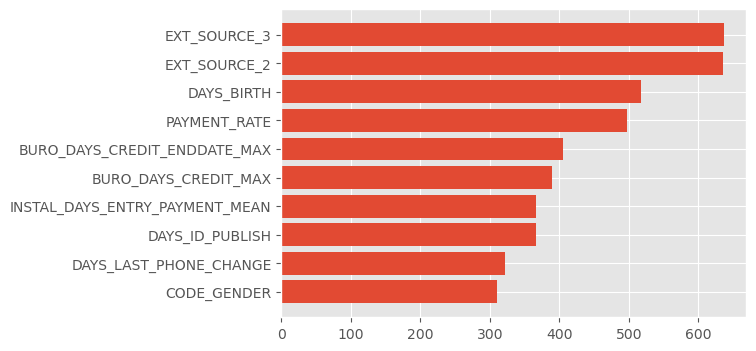

In [134]:
x = feature_importances_top.sort_values('importance')['feature']
y = feature_importances_top.sort_values('importance')['importance']

plt.figure(figsize=(6,4))
plt.barh(x, y)
plt.show()

- dddddd

### SHAP
- La méthode SHAP (SHapley Additive exPlanations) consiste à calculer la valeur de Shapley pour toutes les variables de tous les individus c’est-à-dire la moyenne de l’impact d’une variable (sur la sortie, donc la prédiction) pour toutes les combinaisons de variables possibles.
- La somme des effets de chaque variable expliquera la prédiction.

In [136]:
# DF, based on which importance is checked
X_importance =xtest

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(lgbm_nv)
shap_values = explainer.shap_values(X_importance)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


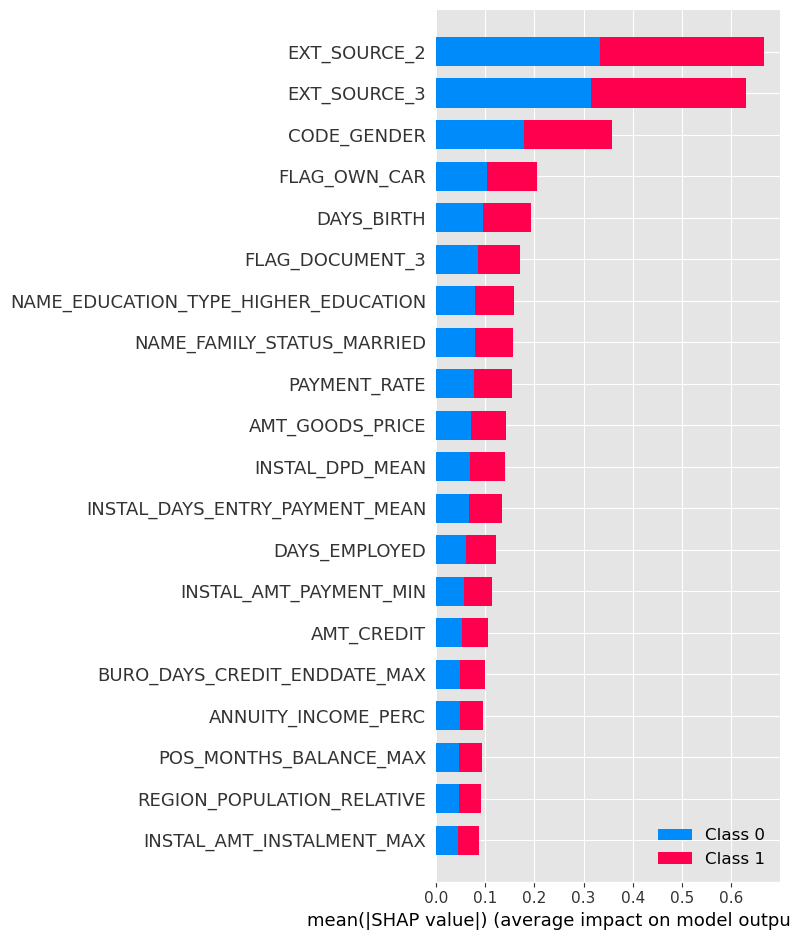

In [137]:
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

- **Bar plot** : l'importance globale des caractéristiques, où l'importance globale de chaque caractéristique est considérée comme la valeur absolue moyenne pour cette caractéristique sur tous les échantillons donnés.

100%|===================| 15507/15518 [10:07<00:00]        

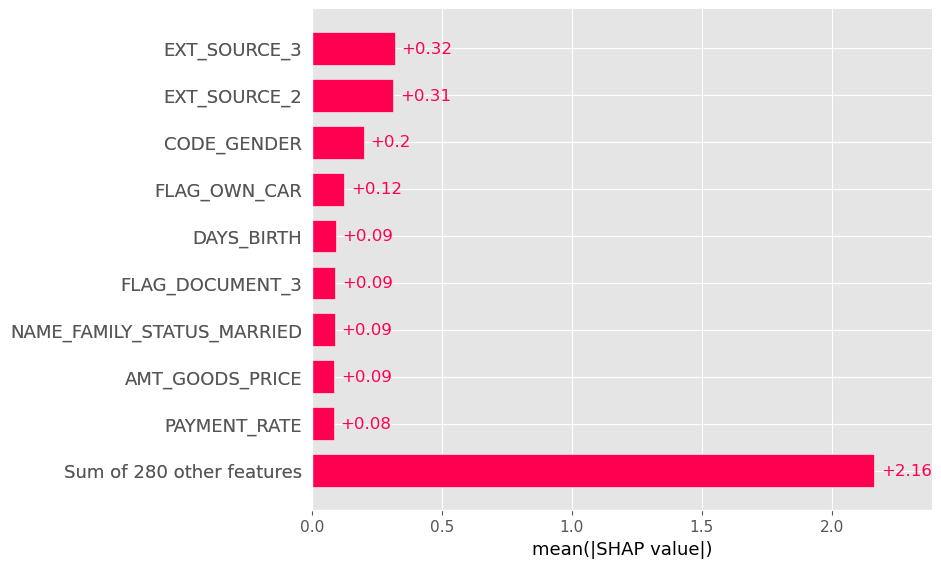

In [138]:
# compute SHAP values

explainer = shap.Explainer(lgbm_nv, X)
shap_values = explainer(X, check_additivity=False)
shap.plots.bar(shap_values)

 **Beeswarm :**

- ce graphique est conçu pour afficher un résumé dense en informations de la manière dont les principales caractéristiques d'un ensemble de données influencent la sortie du modèle.
- Chaque instance de l'explication donnée est représentée par un seul point sur chaque graphique de caractéristiques. La position x du point est déterminée par la valeur SHAP (shap_values.value[instance,feature]) de cette caractéristique, et les points s'empilent le long de chaque ligne de caractéristique pour montrer la densité.
- La couleur est utilisée pour afficher la valeur originale d'une caractéristique (shap_values.data[instance,feature]).

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


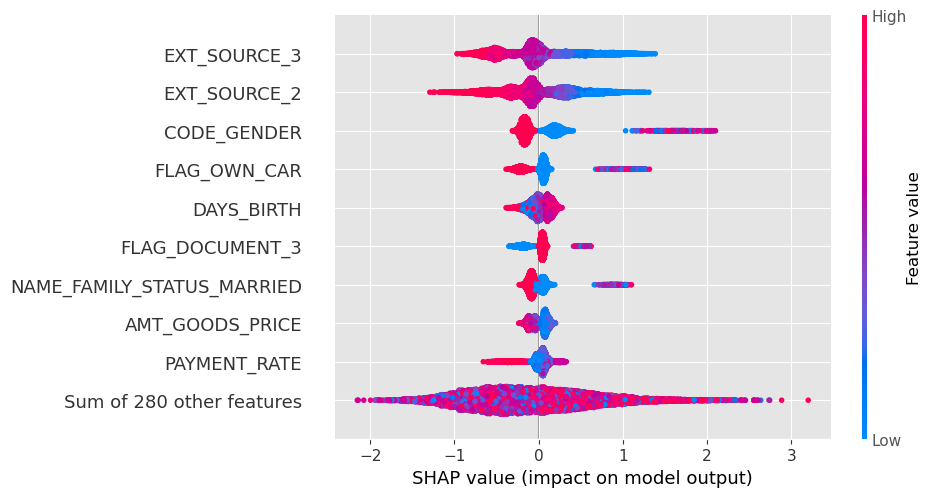

In [139]:
shap.plots.beeswarm(shap_values)

###### Enregistrement du modèle

In [90]:
#Sauvegarde du modèle
joblib.dump(lgbm_nv, 'model.joblib')

['model.joblib']

In [91]:
#Sauvegarde de Shap explainer
joblib.dump(explainer, "shap_explainer.joblib")

['shap_explainer.joblib']

###### Conclusion


-Nous avons commencé par effectuer une analyse exploratoire des données en nous appuyant sur un kernel existant.
- Nous avons ensuite sélectionné le meilleur modèle en prenant soin de comparer chaque modèle avec strictement les mêmes jeux de données pour ne pas fausser les résultats.
- Les modèles on été comparés selon la métrique ROC AUC.
- Le modèle que nous avons sélectionné est LGBMClassifier.

- L'algorithme nous retourne alors une probabilité, pour chaque client, d'appartenir à la classe mauvais client ou bon client.

- Nous avons vu qu'il est plus risqué de prêter à un mauvais client que de ne pas prêter à un bon client.

### Fin

In [68]:
#Sauvegarde des données
df_final.sort_values(by=["SK_ID_CURR"], inplace=True)
df_final.reset_index(drop=True, inplace=True)
df_exp = df_final.sample(5000)


In [69]:
counter = Counter(df_exp['TARGET'])
print(counter)

Counter({0.0: 4598, 1.0: 402})


In [70]:
df_positif = df_exp[df_exp['TARGET'] == 1].sample(400)
df_negatif = df_exp[df_exp['TARGET'] == 0].sample(400)

In [77]:
df_positif = df_exp[df_exp['TARGET'] == 1].sample(2)
df_negatif = df_exp[df_exp['TARGET'] == 0].sample(2)

In [83]:
df_dashboard = pd.concat([df_positif,df_negatif], axis=0)

In [84]:
df_dashboard.index

Int64Index([22916, 51347, 44932, 82315], dtype='int64')

In [85]:
counter = Counter(df_dashboard['TARGET'])
print(counter)

Counter({1.0: 2, 0.0: 2})


In [86]:
df_dashboard.to_pickle("df.gz", compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})
#del df_final, df_exp

In [76]:
df_dashboard[df_dashboard['SK_ID_CURR'] == 305476]['TARGET']

Series([], Name: TARGET, dtype: float64)

In [18]:
# On sauvegarde en csv les données test qui seront nos clients d'exemples pour API et dashboard
#index_test = X_test.index.tolist()
X_test_with_id = df_final.loc[index_test]
X_test_with_id.to_csv('df2.csv',index=False)

In [25]:
df_positif = X_test_with_id[X_test_with_id['TARGET'] == 1].sample(100)
df_negatif = X_test_with_id[X_test_with_id['TARGET'] == 0].sample(100)


In [37]:
df_positif['SK_ID_CURR']

119666    238770
277556    421603
176646    304699
281948    426585
168164    294932
           ...  
33656     138989
292054    438340
184242    313555
107395    224603
33553     138864
Name: SK_ID_CURR, Length: 100, dtype: int64

In [26]:
df2_dashboard = pd.concat([df_positif,df_negatif], axis=0)

In [29]:
df2_dashboard.to_csv('df3.csv',index=False)

In [35]:
df2_dashboard[df2_dashboard['SK_ID_CURR']==238770]['TARGET']

119666    1.0
Name: TARGET, dtype: float64

In [44]:
xtest.to_csv('df4.csv',index=False)

In [45]:
xtest

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
33596,0.125197,-2.222357,-2.102123,-1.377734,-1.687944,-1.484652,-1.858427,-1.454589,-15.537159,3.671817,...,-0.804547,-0.760256,-0.361756,-0.547225,-0.760947,-0.736228,0.588881,1.561388,0.737089,-0.998273
228204,-4.327249,2.251422,-2.102123,0.532374,-1.687935,-1.484652,-1.858400,-1.454589,-12.142215,3.671970,...,-0.804491,-0.760254,-0.361680,-0.547217,-0.760899,-0.736226,0.594558,1.564328,0.737083,-0.975548
24786,-4.327249,-2.222357,-2.102123,-1.377734,-1.687933,-1.484650,-1.858289,-1.454588,-100.760855,3.672185,...,-0.804557,-0.760256,-0.361782,-0.547225,-0.760956,-0.736228,0.593959,1.565350,0.737091,-0.995748
46425,-4.327249,2.251422,2.613463,0.532374,-1.687939,-1.484651,-1.858424,-1.454588,27.960557,3.671857,...,-0.804519,-0.760252,-0.361811,-0.547205,-0.760923,-0.736224,0.594540,1.564251,0.737064,-0.925681
37071,-4.327249,-2.222357,2.613463,-1.377734,-1.687933,-1.484652,-1.858411,-1.454589,-10.763019,3.671957,...,-0.804551,-0.760255,-0.361806,-0.547225,-0.760951,-0.736227,0.594497,1.565041,0.737085,-0.971761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136350,0.125197,-2.222357,-2.102123,-1.377734,-1.687926,-1.484649,-1.858399,-1.454588,-74.842582,3.671537,...,-0.804554,-0.760256,-0.361775,-0.547225,-0.760953,-0.736228,0.589637,1.561219,0.737078,-0.986911
126369,0.125197,-2.222357,-2.102123,-1.377734,-1.687943,-1.484652,-1.858423,-1.454589,-31.344866,3.671648,...,-0.804554,-0.760255,-0.361813,-0.547225,-0.760954,-0.736227,0.594515,1.564915,0.737080,-0.954087
132777,-4.327249,-2.222357,2.613463,2.442482,-1.687917,-1.484650,-1.858347,-1.454586,133.150766,3.671914,...,-0.804454,-0.760255,-0.361811,-0.547222,-0.760875,-0.736227,0.592762,1.564525,0.737090,-0.996379
228342,0.125197,-2.222357,2.613463,-1.377734,-1.687930,-1.484649,-1.858397,-1.454588,18.465324,3.671559,...,-0.804524,-0.760253,-0.361807,-0.547219,-0.760929,-0.736225,0.594522,1.564138,0.737069,-0.942093


### Fin